# QoE Classification using SVD + Neural Network
This notebook performs classification of MOS values using a neural network (MLPClassifier) with Truncated SVD for dimensionality reduction.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import plot_model



In [2]:
# Load the dataset (ensure it is uploaded to the same environment)
from google.colab import drive
drive.mount('/content/gdrive')
file_path = '/content/gdrive/My Drive/ML/dataset.csv'

# Load the dataset

with open('/content/gdrive/My Drive/ML/column-names.txt', 'r') as f :
  column_lines = f.readlines()

# Extraction propre des noms de colonnes depuis le format SQL
columns = [line.split('|')[1].strip() for line in column_lines if '|' in line and 'Field' not in line and '---' not in line]
df = pd.read_csv(file_path, header=None, names=columns)
X = df.drop(columns=['QoE_ITU_046'])  # Features
y_cont = df['QoE_ITU_046'].values  # Continuous MOS target
df.head()
df.info()
df.describe().T


Mounted at /content/gdrive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111919 entries, 0 to 111918
Columns: 270 entries, videoID to QoE_ITU_046
dtypes: float64(98), int64(170), object(2)
memory usage: 230.5+ MB


,count,mean,std,min,25%,50%,75%,max
bitrates_144p,111919.0,8.433258e+04,20668.859700,0.0,80330.500000,9.181100e+04,9.694900e+04,2.248400e+05
bitrates_240p,111919.0,1.614884e+05,56534.866093,0.0,123167.500000,1.734400e+05,2.089205e+05,9.127370e+05
bitrates_360p,111919.0,2.969415e+05,105257.645127,0.0,226045.500000,3.190800e+05,3.848440e+05,1.737032e+06
bitrates_480p,111919.0,5.182005e+05,198978.759166,0.0,374536.000000,5.480470e+05,6.891835e+05,2.469066e+06
bitrates_720p,111919.0,1.042117e+06,403614.412299,0.0,755894.000000,1.104771e+06,1.388100e+06,6.597562e+06
...,...,...,...,...,...,...,...,...
QoE_Linear3,111919.0,3.421945e+00,1.536845,0.0,2.354365,3.929890e+00,4.784930e+00,5.000000e+00
QoE_LD_SD_HD,111919.0,1.118353e+00,0.848809,0.0,0.000000,1.000000e+00,2.000000e+00,2.000000e+00
QoE_ITU_023,111919.0,4.701973e+00,1.103947,-1.0,5.000000,5.000000e+00,5.000000e+00,5.000000e+00
QoE_ITU_035,111919.0,3.508724e+00,1.218091,-1.0,2.888710,3.816160e+00,4.440985e+00,5.000000e+00


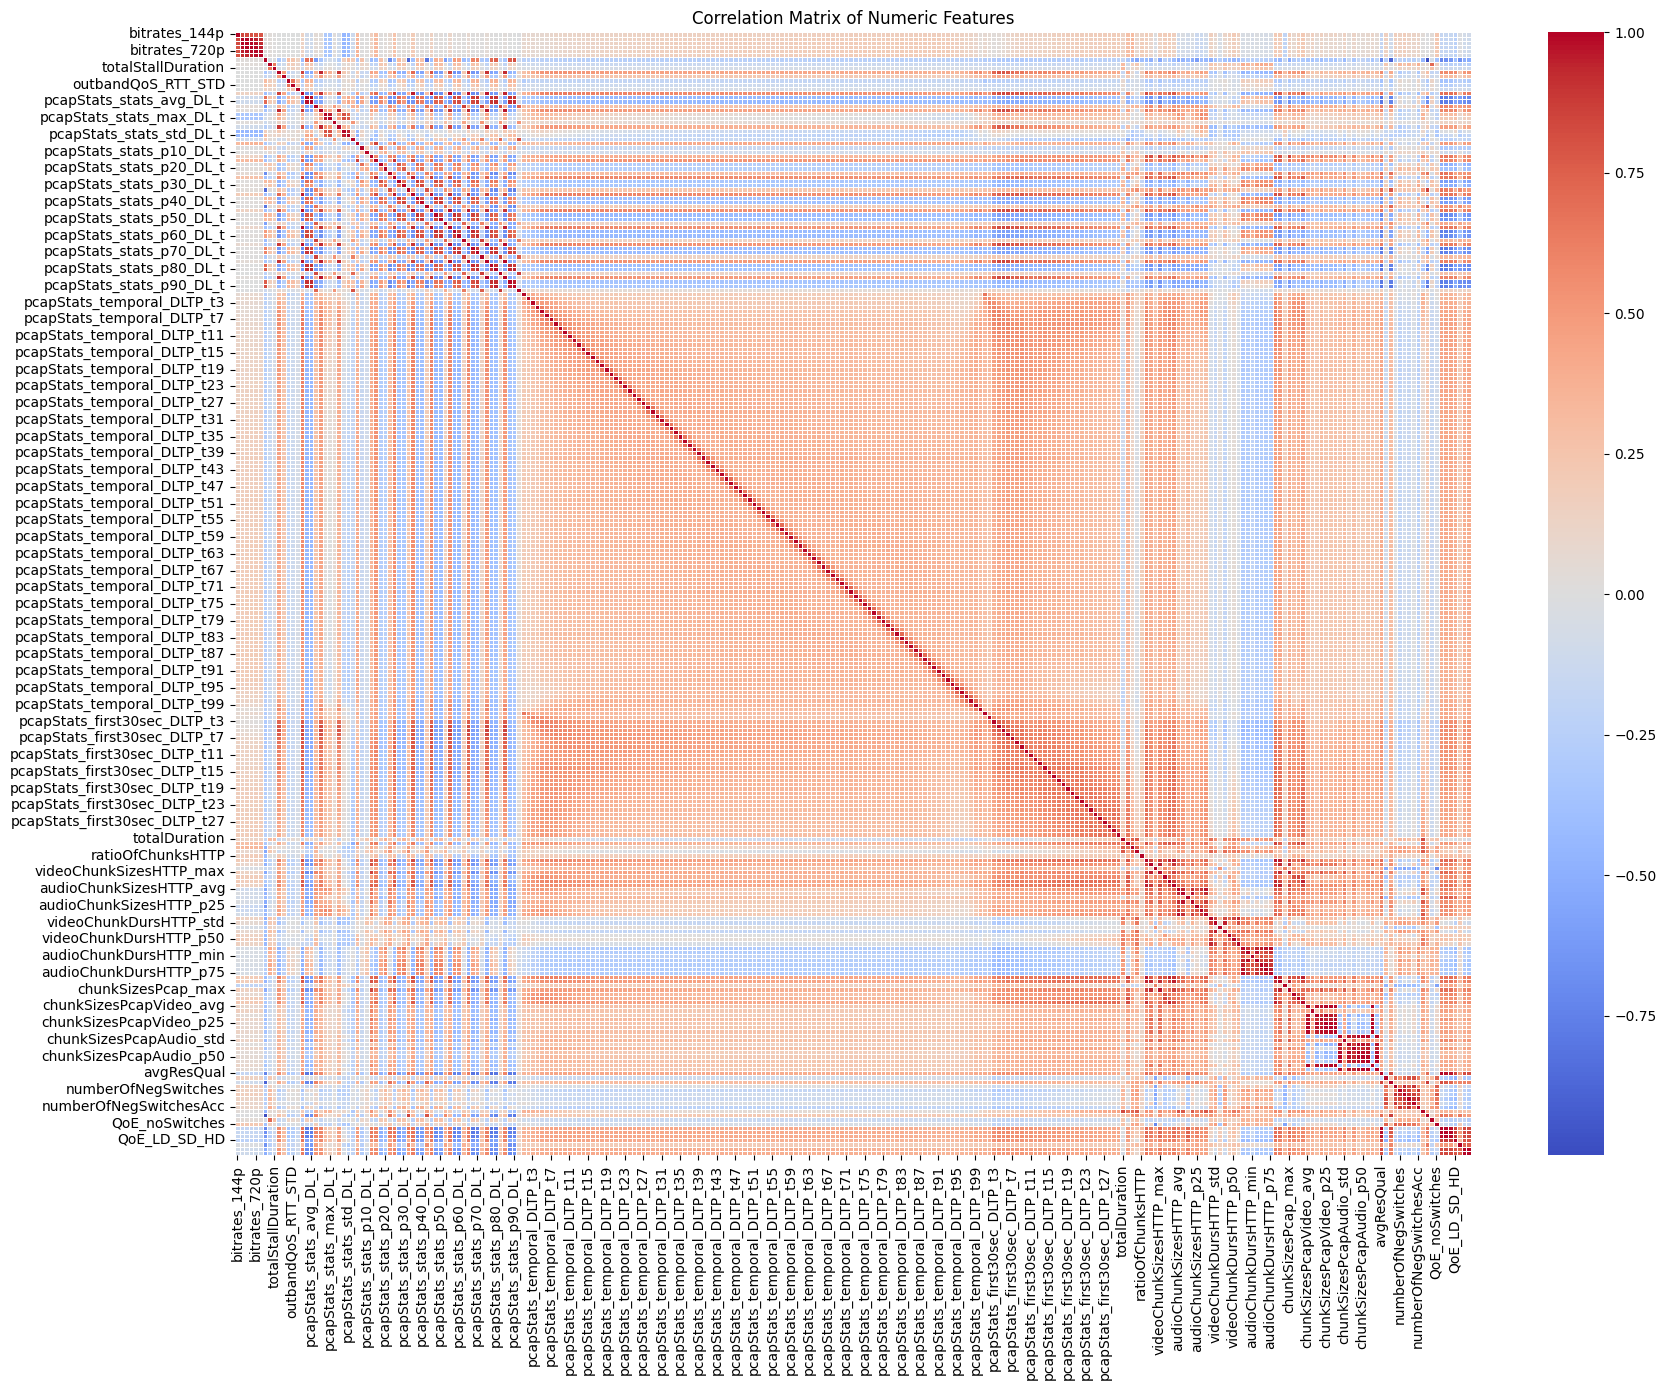

In [3]:
# Compute the correlation
numeric_df = df.select_dtypes(include=['number'])
correlation_matrix = numeric_df.corr()
# Plot it
plt.figure(figsize=(18, 14))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, annot=False, linewidths=0.5)
plt.title("Correlation Matrix of Numeric Features")
plt.tight_layout()
plt.show()


<Axes: >

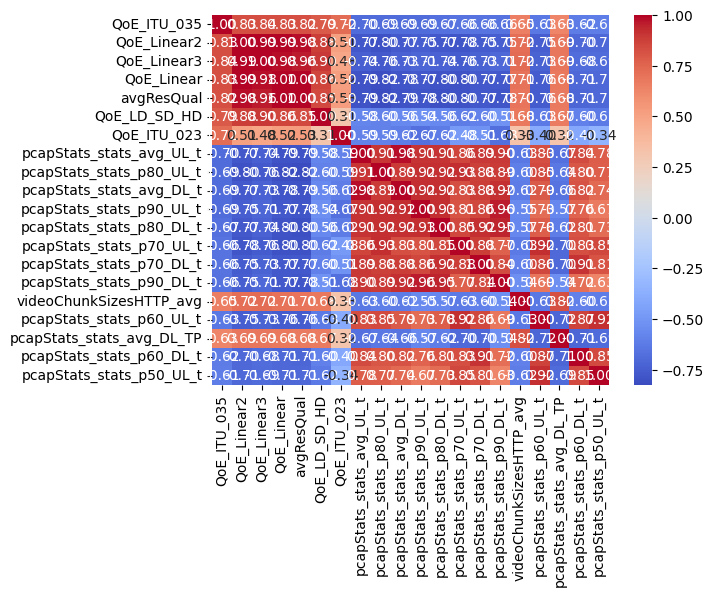

In [4]:
# Observe only the most correlated with the MOS
correlated_with_mos = correlation_matrix['QoE_ITU_046'].abs().sort_values(ascending=False)
top_features = correlated_with_mos[1:21].index  # exclude 'mos' itself
sns.heatmap(df[top_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")

In [5]:
# Compute correlation matrix
X = X.select_dtypes(include=["number"])
corr_matrix = X.corr().abs()
target = "QoE_ITU_046"
# Upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Identify highly correlated pairs (above threshold)
threshold = 0.95
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
features = df.select_dtypes(include=["float", "int"]).drop(columns=[target], errors="ignore").columns.tolist()
valid_features = df[features].isna().mean()[lambda x: x < 0.3].index.tolist()
df_clean = df[valid_features + [target]].dropna()

# Define X and y
X = df_clean[valid_features]
y = df_clean[target]
print(f"Dropping {len(to_drop)} highly correlated features:")
print(to_drop)


# Drop them
X = X.drop(columns=to_drop)

Dropping 37 highly correlated features:
['bitrates_360p', 'bitrates_480p', 'bitrates_720p', 'bitrates_1080p', 'pcapStats_stats_avg_DL_t', 'pcapStats_stats_max_DL_t', 'pcapStats_stats_p40_DL_TP', 'pcapStats_stats_p50_DL_TP', 'pcapStats_stats_p60_DL_TP', 'pcapStats_stats_p70_DL_TP', 'pcapStats_stats_p80_DL_TP', 'pcapStats_stats_p90_DL_TP', 'pcapStats_stats_p90_DL_t', 'videoChunkSizesHTTP_p75', 'audioChunkSizesHTTP_max', 'audioChunkSizesHTTP_p75', 'audioChunkDursHTTP_max', 'audioChunkDursHTTP_p50', 'audioChunkDursHTTP_p75', 'chunkSizesPcap_avg', 'chunkSizesPcap_std', 'chunkSizesPcap_max', 'chunkSizesPcapVideo_min', 'chunkSizesPcapVideo_max', 'chunkSizesPcapVideo_p25', 'chunkSizesPcapVideo_p50', 'chunkSizesPcapVideo_p75', 'chunkSizesPcapAudio_min', 'chunkSizesPcapAudio_p25', 'chunkSizesPcapAudio_p50', 'chunkSizesPcapAudio_p75', 'kmeansCenterVideo', 'kmeansCenterAudio', 'QoE_JT', 'QoE_Linear', 'QoE_Linear2', 'QoE_Linear3']


In [6]:
# Drop rows with missing values
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [7]:

# Select numeric features and drop columns with too many NaNs

# Quantize MOS target into 4 classes
y_class = np.digitize(y, bins=[2.0, 3.0, 4.0])
y_cat = to_categorical(y_class, num_classes=4)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42, stratify=y_class)

In [8]:
# First MLP without dimensionality reduction
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []
train_losses = []
val_losses = []

# Define Keras model
def create_model(input_dim):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(input_dim,)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

for train_idx, test_idx in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y_cat[train_idx], y_cat[test_idx]

    model = create_model(X_train.shape[1])
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(X_train, y_train,
                        validation_split=0.1,
                        epochs=20,
                        batch_size=32,
                        verbose=0,
                        callbacks=[early_stop])

    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    cv_scores.append(acc)
    print(f"Fold accuracy: {acc:.4f}")
    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])

print(f"\nAverage CV accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold accuracy: 0.9622
Fold accuracy: 0.9625
Fold accuracy: 0.9603
Fold accuracy: 0.9635
Fold accuracy: 0.9603

Average CV accuracy: 0.9618 ± 0.0013


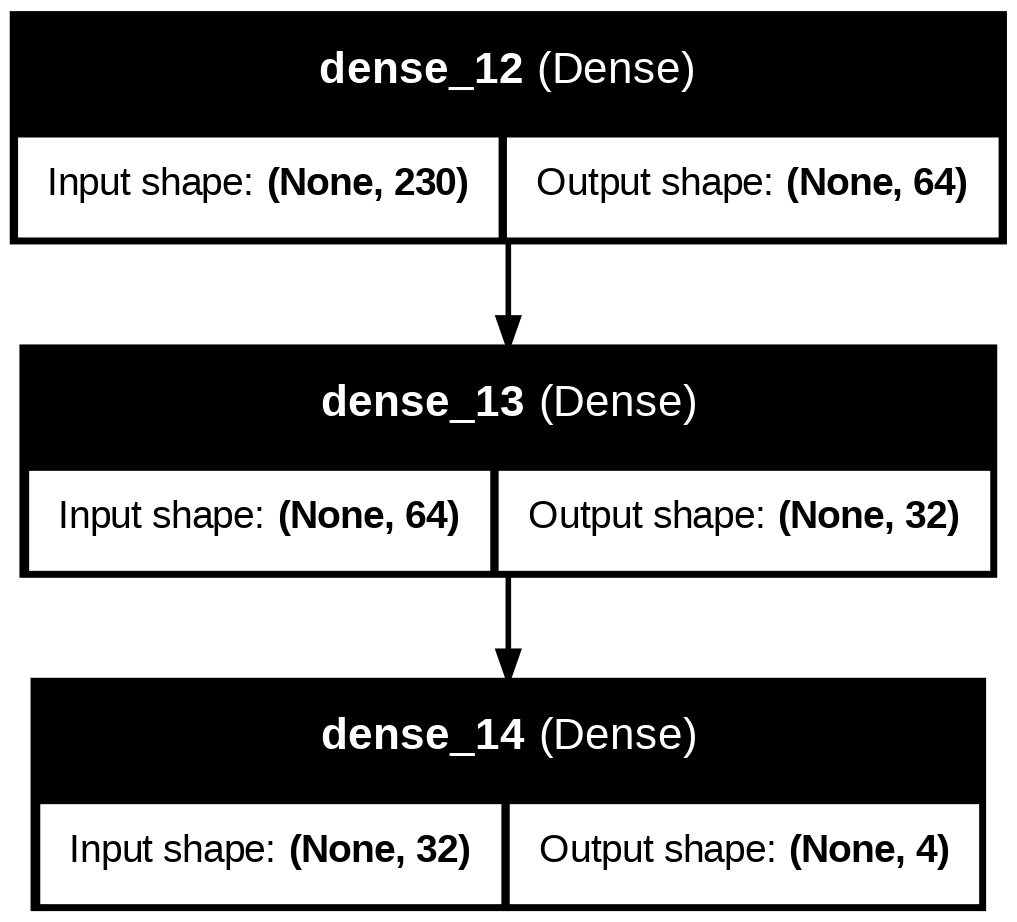

In [9]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


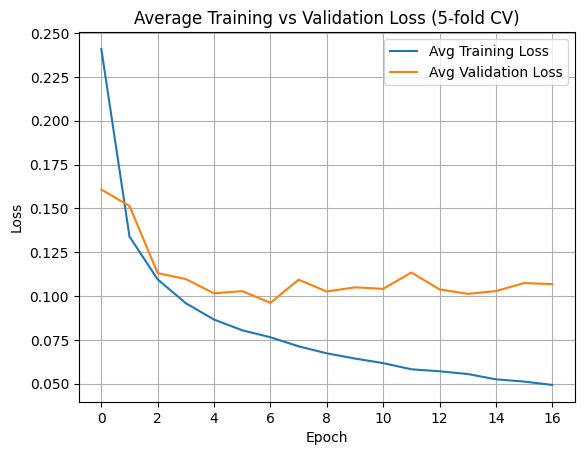

In [10]:
max_len = max(len(l) for l in train_losses)
train_losses_padded = np.array([l + [np.nan]*(max_len - len(l)) for l in train_losses])
val_losses_padded = np.array([l + [np.nan]*(max_len - len(l)) for l in val_losses])

# Compute average loss curves
avg_train_loss = np.nanmean(train_losses_padded, axis=0)
avg_val_loss = np.nanmean(val_losses_padded, axis=0)

# Plot average loss curves
plt.plot(avg_train_loss, label='Avg Training Loss')
plt.plot(avg_val_loss, label='Avg Validation Loss')
plt.title('Average Training vs Validation Loss (5-fold CV)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# Pipeline: StandardScaler → TruncatedSVD → MLPClassifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svd', TruncatedSVD(n_components=20, random_state=42)),
    ('mlp', MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation='relu',
        solver='adam',
        early_stopping =True,
        alpha=0.001,
        max_iter=300,
        random_state=42
    ))
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svd', TruncatedSVD(n_components=20, random_state=42)),
                ('mlp',
                 MLPClassifier(alpha=0.001, early_stopping=True,
                               hidden_layer_sizes=(64, 32), max_iter=300,
                               random_state=42))])

In [30]:
# Extract the SVD step from your pipeline
svd = pipeline.named_steps['svd']

# Get the component loadings (shape: [n_components, n_features])
components = svd.components_

# Get the feature names (important!)
feature_names =  X.columns # assuming X_train was used to fit

# Get the absolute values of contributions for better ranking
importance = np.abs(components).mean(axis=0)

# Pair them with feature names
feature_importance = pd.Series(importance, index=feature_names)

# Top 30 most influential features (across all SVD components)
top_features = feature_importance.sort_values(ascending=False).head(30)
print(top_features)

stallingNumber                  0.101665
outbandQoS_RTT_STD              0.090130
QoE_noStall                     0.088307
totalStallDuration              0.081705
outbandQoS_RTT                  0.080443
chunkSizesPcapAudio_avg         0.073144
pcapStats_temporal_DLTP_t96     0.072891
chunkSizesPcapAudio_max         0.072101
chunkSizesPcapVideo_avg         0.070693
pcapStats_stats_p10_UL_t        0.070359
pcapStats_temporal_DLTP_t95     0.069720
pcapStats_stats_std_DL_t        0.069518
pcapStats_temporal_DLTP_t97     0.068124
pcapStats_first30sec_DLTP_t1    0.067089
pcapStats_stats_std_UL_t        0.066255
bitrates_144p                   0.066214
pcapStats_temporal_DLTP_t89     0.065770
QoE_ITU_023                     0.064756
pcapStats_stats_p20_UL_t        0.064379
pcapStats_temporal_DLTP_t90     0.064345
pcapStats_temporal_DLTP_t1      0.063916
pcapStats_temporal_DLTP_t83     0.063777
pcapStats_temporal_DLTP_t88     0.063569
bitrates_240p                   0.063194
pcapStats_tempor

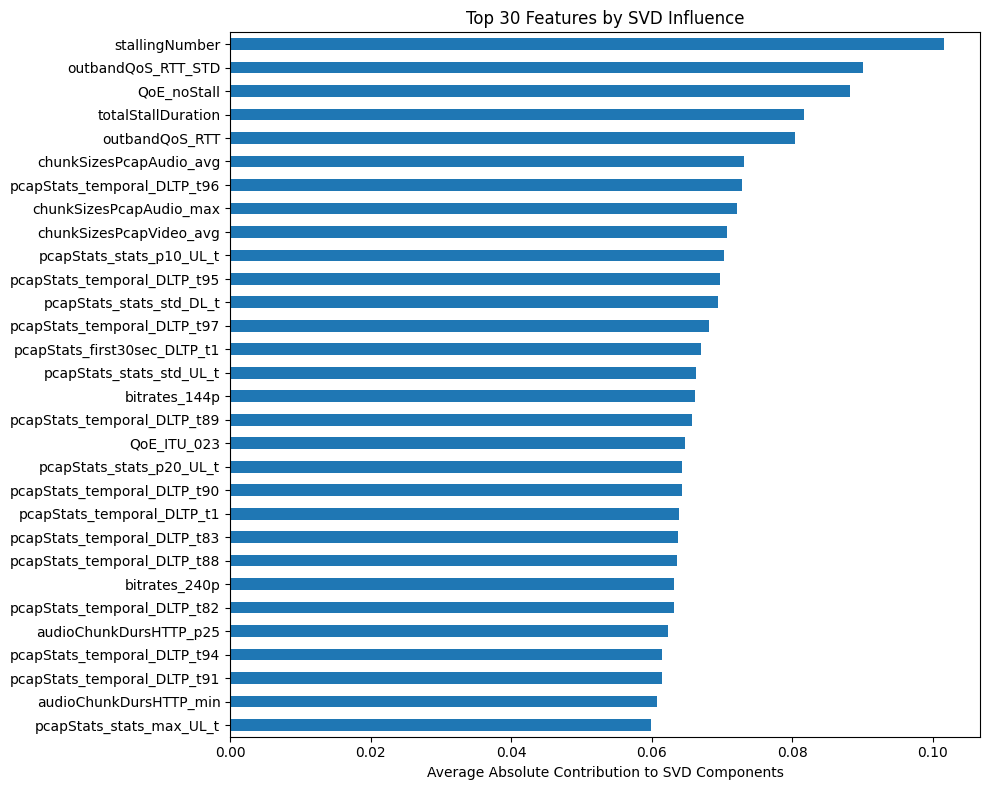

In [31]:
top_features.sort_values().plot(kind='barh', figsize=(10, 8), title="Top 30 Features by SVD Influence")
plt.xlabel("Average Absolute Contribution to SVD Components")
plt.tight_layout()
plt.show()

In [32]:
# Evaluate the model
y_pred = pipeline.predict(X_test)
y_test_labels = np.argmax(y_test, axis=1) if y_test.ndim > 1 else y_test
y_pred_labels = np.argmax(y_pred, axis=1) if y_pred.ndim > 1 else y_pred
print(classification_report(y_test_labels, y_pred_labels))

              precision    recall  f1-score   support

           0       0.73      0.86      0.79      2546
           1       0.81      0.78      0.79      3860
           2       0.84      0.83      0.83      6375
           3       0.94      0.92      0.93      9602

    accuracy                           0.86     22383
   macro avg       0.83      0.85      0.84     22383
weighted avg       0.86      0.86      0.86     22383



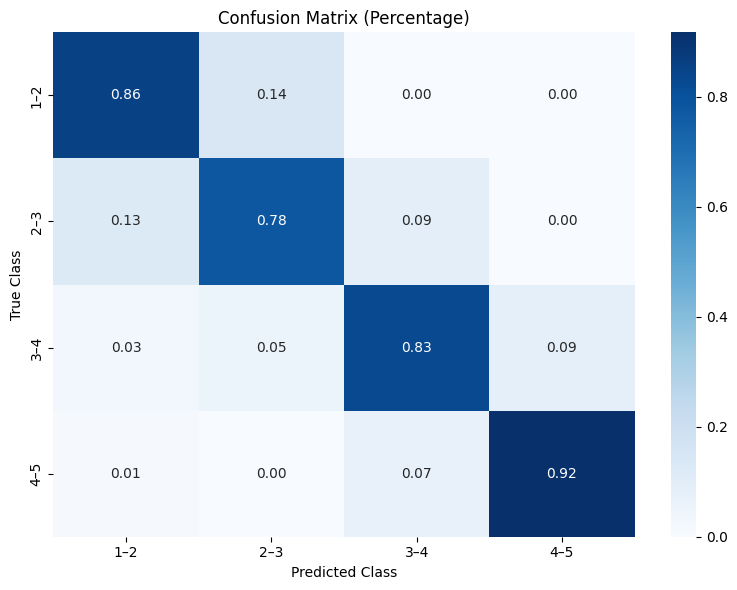

In [33]:
# Confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
labels = ["1–2", "2–3", "3–4", "4–5"]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix (Percentage)")
plt.tight_layout()
plt.show()
